# Grid Game discussion and results

The code for grid game creates a GridGame object which is initialised with a grid size (set by tuple of integers), a mode and a random seed.

The parent class is called GridGame and holds most of the attibutes and methods needed to play and solve the games. There are two subclasses: Classic and Relative. There are two methods within these subclasses. One is `.move_time()` which calculates the time need to move to an adjacent cell. The other is an abstractmethod call `.time_on_first_cell()` which returns the value on the first cell for the classic game, and 0 for the relative game. To calculate the correct length of path, the parent methods need to call this. 

All other methods are shared: the only difference between the two modes is that the "time cost" of moving from one square to another is different depending on the node.

The next step is to initialise the grid values using the `.set_grid_values()` method. The user can choose a distribution ("integers", "geometric", binomial" or "normal" ) and set paramers for the distribution with key words corresponding to the methods of `numpy.random.default_rng` methods.

The grid can be visualised using `.visualise_grid()` method, which takes an optional `path` argument. path should be a list of grid coordinates.

The `.solve_game()` method runs the "naive" algorithm to solve the game. The alogirthm is actually pretty good and I think well always solve the problem. It is not as efficient as Djikstra as it calculates moves for every square in the grid to find shortes path, and then repeats trying to find improvements. When no improvements are found, it stops. Setting `show_iterations=True` shows the fastest path after each iteration. The user can see the path slowly converging on the best solution.

In [1]:
from grid_game import *
from to_html import *
from matplotlib import pyplot as plt

In [2]:
save_html('grid_game','task1_report','.')

In [3]:
# set random seed here for brevity
random_seed=2

## How does the naive algorithm work?

I developed this algorithm before consulting for solutions online. I was quite pleased with it, but unsurpsingly, Djikstra algorithm is more elegant and efficient.

The idea is that a fastest time and fastest path is stored for each cell in the grid.  

For the first iteration, we restrict all moves to be down or right - i.e. closer to the goal. A shortest physcal route is a good first guess at a viable quickest route. We start at the bottom right of the grid, and then consider the cells in the diagonal above the last cell. These have to move to the last cell, so we record the route to the finish from each cell, and the length of time needed to get there. We then move the diagonal up one. If there is a choice of moves from a cell, it adds the time needed to move to each neihbouring cell to the shortest path from that cell. It then picks the quickest overall route and stores the route and length of time.

In the example below, the initial best path is down to the bottom corner and right to the end. Marked by blue arrows. This will take 9 units of time to complete. The best route from cell (0,2) is marked by red arrows and the time needed is 0. From cell (1,2) the best route is also marked with blue arrows, and takes time of 9. This is because moves are restricted to be right or down.

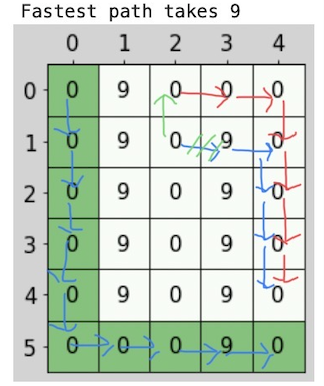

In the next iteration, we free the player to move in any direction. The scan will again start from the diagonal above the target cell and move up. When the scan gets to cell (1,3) it will realise that a move UP to (1,2) will result in a (longer) path that is quicker - taking 0 time. On each iteration, cells (2,3), (3,3) and (4,3) will flip to moving UP in turn until eventually cell (5,3) finds an alternative route with a time cost of 0, and the algorithm finishes. It has found a route costing 0 time and will not change after that.

Last iteration and finish, with a joyous "wahoo!"

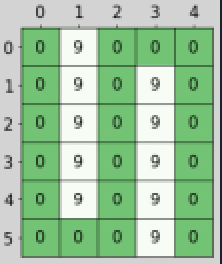

The code has to scan all m x n grid squares on each iteration. The largest number of iterations needed it surely bound by m x n and in practice will be very low. Therefore a finger in the air estimate of worst case complexity is $O(n^2)$ where n is the larger of the two grid dimensions.

## Two easy examples to show the code in action

To illustrate the code, we show one example each of Classic and Relative subclass.

### Classic

Parameters:
* grid size is 5 x 7
* grid values are integers between 0 and 9

In this example both algorithims find the same path


Starting grid:



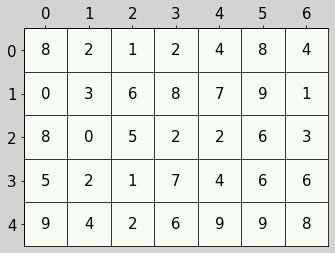


----------
iterations of fastest path found by naive algorithm

Fastest path takes 35


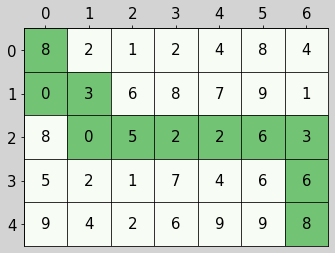


Code required 1 iterations

----------
Djikstra algorithm:
fastest path takes 35

Path calculated by djikstra algorithm:



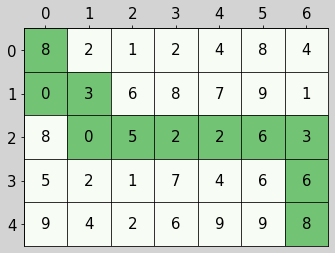

CPU times: user 405 ms, sys: 10 ms, total: 415 ms
Wall time: 412 ms


In [6]:
%%time
game = Classic(size=(5,7), random_seed=random_seed)
game.set_grid_values(distribution="integers", high=10)
print("\nStarting grid:\n")
game.visualise_grid()
print("\n" + "-"*10)
print("iterations of fastest path found by naive algorithm")
game.solve_game(show_iterations=True)
print("\n" + "-"*10)
print("Djikstra algorithm:")
game.djikstra()
print("\nPath calculated by djikstra algorithm:\n")
game.visualise_grid(game.djikstra_path)

### Relative

Parameters:
* grid size is 20 x 20
* grid values are geometrically distributed with parameter $p=0.1$

This example demonstrates how the naive algorithm works. The first iteration is the fastest path with only downwards and rightwards moves allowed. It then tries to find faster routes by allowing upwards and leftwards moves as well. After finding the initial route, it makes two more iterations: decreasing the time of the path by 2 and 1 unit until it can't improve and stops. 

Both the naive and the Djikstra algorithm find the same length path, but in this case you can see that they have randomly settled on different solutions. Neither algorithm gives a list of best paths: they both randomly settle on one best path.


Starting grid:



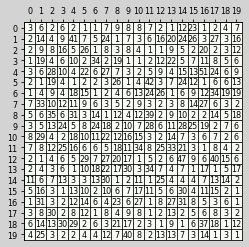


----------
iterations of fastest path found by naive algorithm

Fastest path takes 151


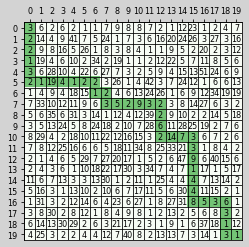

Wahoo! Fastest path now takes 149


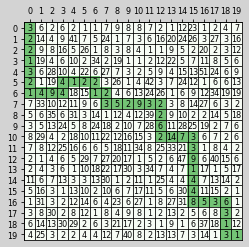

Wahoo! Fastest path now takes 148


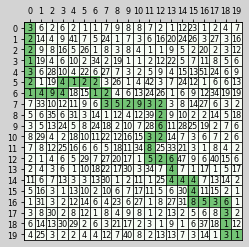


Code required 7 iterations

----------
Djikstra algorithm:
fastest path takes 148

Path calculated by djikstra algorithm:



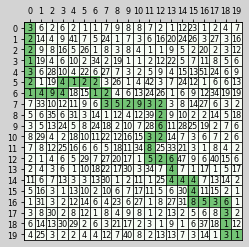

CPU times: user 2.99 s, sys: 101 ms, total: 3.09 s
Wall time: 3.08 s


In [5]:
%%time
game = Classic(size=(20,20), random_seed=20)
game.set_grid_values(distribution="geometric", p = 0.1)
print("\nStarting grid:\n")
game.visualise_grid()
print("\n" + "-"*10)
print("iterations of fastest path found by naive algorithm")
game.solve_game(show_iterations=True)
print("\n" + "-"*10)
print("Djikstra algorithm:")
game.djikstra()
print("\nPath calculated by djikstra algorithm:\n")
game.visualise_grid(game.djikstra_path)

## How does Djikstra algorithm work in my code?

I didn't consult any online resources on how to write the python code for Djikstra. I just looked at the description of the algorithm on Wikipedia and implemented it as best as I could. With the benefit of several weeks more coding experience I would do a different and better job.

The main `.djikstra()` method calls on the following class methods:
* `.moves()` - the allowable moves from a certain cell. Will be up, down, left, right, as long as they are in the grid. Shared with the naive algorithm.
* `.move_time()` the subclass specific method which calculates how long the agent has to stay in a cell for. Shared with naive algorithm.
* `.create_unvisited_list()` method creates the initial list of unvisited nodes: which is just a list of all nodes in the grid.
* `.djikstra_shortest_path()` method which uses the "previous" cell information held by each cell to iteratively reconstruct the current quickest path from the finishing cell to the starting cell, using the "previous cell" information held in the `self.previous_node` attribute - which is a dictionary with keys that are 2-tuples representing grid location of a node.

The method `.djikstra()` solves the game using Djikstra's algorithm. 
The algorithm initialises a priority queue